In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

### Инициализация функций для работы с pd.Dataframe для данных

In [3]:
def init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R):
    if not ((beta_distib_consensus_data['N'] == N) 
            & (beta_distib_consensus_data['alpha'] == alpha) 
            & (beta_distib_consensus_data['beta'] == beta) 
            & (round(beta_distib_consensus_data['eps'],2) == round(R,2))
            ).any():
        beta_distib_consensus_data.at[experiment, "N"] = N
        beta_distib_consensus_data.at[experiment, "alpha"] = alpha
        beta_distib_consensus_data.at[experiment, "beta"] = beta
        beta_distib_consensus_data.at[experiment, "eps"] = round(R,2)
        beta_distib_consensus_data.at[experiment, "consensus_x"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_y"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_probabity"] =0
        beta_distib_consensus_data.at[experiment, "simulation_time"] =0
        beta_distib_consensus_data.at[experiment, "simulation_count"] = 0

def update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast):
    beta_distib_consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    beta_distib_consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    beta_distib_consensus_data.at[experiment, "consensus_probabity"] +=1
    beta_distib_consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    

dtypes = {
    'N': np.int64,
    'alpha': np.float64,
    'beta': np.float64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
# beta_distib_consensus_data = pd.DataFrame(columns=["N", "alpha", "beta", "eps", "consensus_x", "consensus_y","consensus_probabity", "simulation_time"], dtype=object)
# beta_distib_consensus_data

#### Загрузка предыдущих результатов

In [4]:
beta_distib_consensus_data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
beta_distib_consensus_data

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,2500,0.50,0.50,0.15,0.000000,0.000000,0.0,0,10
1,2500,1.00,1.00,0.15,0.000000,0.000000,0.0,0,10
2,2500,1.50,1.50,0.15,0.000000,0.000000,0.0,0,10
3,2500,2.00,2.00,0.15,0.000000,0.000000,0.0,0,10
4,2500,2.50,2.50,0.15,4.003755,3.964977,8.0,153,10
...,...,...,...,...,...,...,...,...,...
2307,50,1.81,0.98,1.00,260.092234,260.267818,400.0,1157,400
2308,50,0.53,1.59,1.00,99.507905,98.847568,400.0,1173,400
2309,50,1.59,0.53,1.00,302.131253,300.454411,400.0,1161,400
2310,50,0.17,0.96,1.00,58.391268,57.416195,400.0,1190,400


In [5]:
unif_dtypes = {
    'N': np.int64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
unif_data = pd.read_csv('unif_distib_consensus_data.csv', sep=";", dtype=unif_dtypes)

#### Обьявление констант

In [6]:
R = 0.2  # радиус доверия
eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n

In [7]:
R_array = [round(i,2)for i in np.arange(0.15, 1.01, 0.05)]
beta_params_array =  np.arange(0.5, 5.1, 0.5)
beta_params_array

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [8]:
def beta_distrib_ab2Esigma(alpha, beta):
    return alpha/(alpha+beta), alpha*beta/((alpha+beta+1)*(alpha+beta)**2)
def beta_distrib_Esigma2ab(E, sigma):
    alpha = (E**2 - E**3) / sigma - E
    beta = (E - E**2) / sigma - 1 - ((E**2 - E**3) / sigma - E)
    return alpha, beta


In [9]:

max_dif = 0.0
for a in np.linspace(0.01, 5, 100):
    for b in np.linspace(0.01, 5, 100):
        a_, b_ = beta_distrib_Esigma2ab(*beta_distrib_ab2Esigma(a, b))
        np.testing.assert_allclose([a, b], [a_, b_], rtol=1e-10)
        max_dif = max(max_dif, abs(a - a_) + abs(b - b_))

print(max_dif)


5.886489212736379e-13


### Моделирование

In [64]:
experiments = 400

#### Фиксированное мат ожидание

In [14]:
mu = 0.25
alphas = [i for i in np.arange(0.5, 5.1, 0.5)]
betas = [round(alphas[i]*(1-mu)/mu, 2) for i in range(len(alphas)) ]
alphas, betas


([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
 [1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5, 12.0, 13.5, 15.0])

#### Фиксированная дисперсия

In [10]:
delta = [round(i,2)for i in np.arange(0.05, 0.41, 0.1)]
delta

[0.05, 0.15, 0.25, 0.35]

In [11]:
mu = []
mean=0.5
for i in delta:
    mu.append(round(mean-i,2))
    mu.append(round(mean+i,2))
mu

[0.45, 0.55, 0.35, 0.65, 0.25, 0.75, 0.15, 0.85]

In [16]:
sigma=0.06
alphas=[]
betas=[]
for m in mu:
    a, b = beta_distrib_Esigma2ab(m, sigma)
    alphas.append(round(a,2))
    betas.append(round(b,2))
alphas, betas

([1.41, 1.72, 0.98, 1.81, 0.53, 1.59, 0.17, 0.96],
 [1.72, 1.41, 1.81, 0.98, 1.59, 0.53, 0.96, 0.17])

#### Расчет

In [66]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for i in range (len(alphas)):
        alpha = alphas[i]
        beta = betas[i]
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                    & (beta_distib_consensus_data['alpha'] == alpha) 
                    & (beta_distib_consensus_data['beta'] == beta) 
                    & (round(beta_distib_consensus_data['eps'],2) == round(R,2)))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

N:50 R:0.15 a:1.41 b:1.72 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 236.72it/s]


N:50 R:0.15 a:1.72 b:1.41 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 243.04it/s]


N:50 R:0.15 a:0.98 b:1.81 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 232.16it/s]


N:50 R:0.15 a:1.81 b:0.98 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 241.01it/s]


N:50 R:0.15 a:0.53 b:1.59 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 230.99it/s]


N:50 R:0.15 a:1.59 b:0.53 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 239.12it/s]


N:50 R:0.15 a:0.17 b:0.96 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 223.97it/s]


N:50 R:0.15 a:0.96 b:0.17 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:01<00:00, 236.19it/s]


N:50 R:0.2 a:1.41 b:1.72 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 165.91it/s]


N:50 R:0.2 a:1.72 b:1.41 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 168.37it/s]


N:50 R:0.2 a:0.98 b:1.81 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 175.41it/s]


N:50 R:0.2 a:1.81 b:0.98 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 171.47it/s]


N:50 R:0.2 a:0.53 b:1.59 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 179.22it/s]


N:50 R:0.2 a:1.59 b:0.53 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 189.87it/s]


N:50 R:0.2 a:0.17 b:0.96 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 191.33it/s]


N:50 R:0.2 a:0.96 b:0.17 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:02<00:00, 194.37it/s]


N:50 R:0.25 a:1.41 b:1.72 func:HK_2D_sim_fast count:0


100%|██████████| 400/400 [00:03<00:00, 113.11it/s]


N:50 R:0.25 a:1.72 b:1.41 func:HK_2D_sim count:86


100%|██████████| 400/400 [00:03<00:00, 118.24it/s]


N:50 R:0.25 a:0.98 b:1.81 func:HK_2D_sim count:171


100%|██████████| 400/400 [00:03<00:00, 124.19it/s]


N:50 R:0.25 a:1.81 b:0.98 func:HK_2D_sim count:200


100%|██████████| 400/400 [00:03<00:00, 126.95it/s]


N:50 R:0.25 a:0.53 b:1.59 func:HK_2D_sim count:229


100%|██████████| 400/400 [00:02<00:00, 139.77it/s]


N:50 R:0.25 a:1.59 b:0.53 func:HK_2D_sim count:230


100%|██████████| 400/400 [00:02<00:00, 140.24it/s]


N:50 R:0.25 a:0.17 b:0.96 func:HK_2D_sim count:233


100%|██████████| 400/400 [00:02<00:00, 168.28it/s]


N:50 R:0.25 a:0.96 b:0.17 func:HK_2D_sim count:233


100%|██████████| 400/400 [00:02<00:00, 168.99it/s]


N:50 R:0.3 a:1.41 b:1.72 func:HK_2D_sim count:233


100%|██████████| 400/400 [00:02<00:00, 141.82it/s]


N:50 R:0.3 a:1.72 b:1.41 func:HK_2D_sim count:557


100%|██████████| 400/400 [00:02<00:00, 143.46it/s]


N:50 R:0.3 a:0.98 b:1.81 func:HK_2D_sim count:869


100%|██████████| 400/400 [00:02<00:00, 141.55it/s]


N:50 R:0.3 a:1.81 b:0.98 func:HK_2D_sim count:1063


100%|██████████| 400/400 [00:02<00:00, 138.80it/s]


N:50 R:0.3 a:0.53 b:1.59 func:HK_2D_sim count:1254


100%|██████████| 400/400 [00:02<00:00, 144.37it/s]


N:50 R:0.3 a:1.59 b:0.53 func:HK_2D_sim count:1294


100%|██████████| 400/400 [00:02<00:00, 144.70it/s]


N:50 R:0.3 a:0.17 b:0.96 func:HK_2D_sim count:1338


100%|██████████| 400/400 [00:02<00:00, 173.17it/s]


N:50 R:0.3 a:0.96 b:0.17 func:HK_2D_sim count:1339


100%|██████████| 400/400 [00:02<00:00, 173.35it/s]


N:50 R:0.35 a:1.41 b:1.72 func:HK_2D_sim count:1340


100%|██████████| 400/400 [00:02<00:00, 176.23it/s]


N:50 R:0.35 a:1.72 b:1.41 func:HK_2D_sim count:1728


100%|██████████| 400/400 [00:02<00:00, 173.35it/s]


N:50 R:0.35 a:0.98 b:1.81 func:HK_2D_sim count:2116


100%|██████████| 400/400 [00:02<00:00, 167.03it/s]


N:50 R:0.35 a:1.81 b:0.98 func:HK_2D_sim count:2464


100%|██████████| 400/400 [00:02<00:00, 163.05it/s]


N:50 R:0.35 a:0.53 b:1.59 func:HK_2D_sim count:2805


100%|██████████| 400/400 [00:02<00:00, 155.33it/s]


N:50 R:0.35 a:1.59 b:0.53 func:HK_2D_sim count:2982


100%|██████████| 400/400 [00:02<00:00, 153.03it/s]


N:50 R:0.35 a:0.17 b:0.96 func:HK_2D_sim count:3158


100%|██████████| 400/400 [00:02<00:00, 179.20it/s]


N:50 R:0.35 a:0.96 b:0.17 func:HK_2D_sim count:3163


100%|██████████| 400/400 [00:02<00:00, 177.66it/s]


N:50 R:0.4 a:1.41 b:1.72 func:HK_2D_sim count:3171


100%|██████████| 400/400 [00:01<00:00, 204.31it/s]


N:50 R:0.4 a:1.72 b:1.41 func:HK_2D_sim count:3570


100%|██████████| 400/400 [00:01<00:00, 205.83it/s]


N:50 R:0.4 a:0.98 b:1.81 func:HK_2D_sim count:3968


100%|██████████| 400/400 [00:02<00:00, 191.47it/s]


N:50 R:0.4 a:1.81 b:0.98 func:HK_2D_sim count:4350


100%|██████████| 400/400 [00:02<00:00, 194.32it/s]


N:50 R:0.4 a:0.53 b:1.59 func:HK_2D_sim count:4733


100%|██████████| 400/400 [00:02<00:00, 174.38it/s]


N:50 R:0.4 a:1.59 b:0.53 func:HK_2D_sim count:5030


100%|██████████| 400/400 [00:02<00:00, 169.59it/s]


N:50 R:0.4 a:0.17 b:0.96 func:HK_2D_sim count:5334


100%|██████████| 400/400 [00:02<00:00, 174.68it/s]


N:50 R:0.4 a:0.96 b:0.17 func:HK_2D_sim count:5376


100%|██████████| 400/400 [00:02<00:00, 170.49it/s]


N:50 R:0.45 a:1.41 b:1.72 func:HK_2D_sim count:5412


100%|██████████| 400/400 [00:01<00:00, 208.04it/s]


N:50 R:0.45 a:1.72 b:1.41 func:HK_2D_sim count:5812


100%|██████████| 400/400 [00:01<00:00, 208.20it/s]


N:50 R:0.45 a:0.98 b:1.81 func:HK_2D_sim count:6212


100%|██████████| 400/400 [00:01<00:00, 202.66it/s]


N:50 R:0.45 a:1.81 b:0.98 func:HK_2D_sim count:6610


100%|██████████| 400/400 [00:01<00:00, 208.05it/s]


N:50 R:0.45 a:0.53 b:1.59 func:HK_2D_sim count:7004


100%|██████████| 400/400 [00:02<00:00, 192.31it/s]


N:50 R:0.45 a:1.59 b:0.53 func:HK_2D_sim count:7373


100%|██████████| 400/400 [00:02<00:00, 188.94it/s]


N:50 R:0.45 a:0.17 b:0.96 func:HK_2D_sim count:7738


100%|██████████| 400/400 [00:02<00:00, 174.64it/s]


N:50 R:0.45 a:0.96 b:0.17 func:HK_2D_sim count:7871


100%|██████████| 400/400 [00:02<00:00, 174.50it/s]


N:50 R:0.5 a:1.41 b:1.72 func:HK_2D_sim count:7987


100%|██████████| 400/400 [00:01<00:00, 219.99it/s]


N:50 R:0.5 a:1.72 b:1.41 func:HK_2D_sim count:8387


100%|██████████| 400/400 [00:01<00:00, 216.63it/s]


N:50 R:0.5 a:0.98 b:1.81 func:HK_2D_sim count:8787


100%|██████████| 400/400 [00:01<00:00, 213.60it/s]


N:50 R:0.5 a:1.81 b:0.98 func:HK_2D_sim count:9187


100%|██████████| 400/400 [00:01<00:00, 210.79it/s]


N:50 R:0.5 a:0.53 b:1.59 func:HK_2D_sim count:9586


100%|██████████| 400/400 [00:01<00:00, 204.11it/s]


N:50 R:0.5 a:1.59 b:0.53 func:HK_2D_sim count:9979


100%|██████████| 400/400 [00:01<00:00, 207.76it/s]


N:50 R:0.5 a:0.17 b:0.96 func:HK_2D_sim count:10367


100%|██████████| 400/400 [00:02<00:00, 183.84it/s]


N:50 R:0.5 a:0.96 b:0.17 func:HK_2D_sim count:10596


100%|██████████| 400/400 [00:02<00:00, 179.01it/s]


N:50 R:0.55 a:1.41 b:1.72 func:HK_2D_sim count:10820


100%|██████████| 400/400 [00:01<00:00, 249.05it/s]


N:50 R:0.55 a:1.72 b:1.41 func:HK_2D_sim count:11220


100%|██████████| 400/400 [00:01<00:00, 252.31it/s]


N:50 R:0.55 a:0.98 b:1.81 func:HK_2D_sim count:11620


100%|██████████| 400/400 [00:01<00:00, 234.77it/s]


N:50 R:0.55 a:1.81 b:0.98 func:HK_2D_sim count:12020


100%|██████████| 400/400 [00:01<00:00, 234.00it/s]


N:50 R:0.55 a:0.53 b:1.59 func:HK_2D_sim count:12420


100%|██████████| 400/400 [00:01<00:00, 216.37it/s]


N:50 R:0.55 a:1.59 b:0.53 func:HK_2D_sim count:12813


100%|██████████| 400/400 [00:01<00:00, 211.71it/s]


N:50 R:0.55 a:0.17 b:0.96 func:HK_2D_sim count:13208


100%|██████████| 400/400 [00:02<00:00, 189.68it/s]


N:50 R:0.55 a:0.96 b:0.17 func:HK_2D_sim count:13531


100%|██████████| 400/400 [00:02<00:00, 182.78it/s]


N:50 R:0.6 a:1.41 b:1.72 func:HK_2D_sim count:13858


100%|██████████| 400/400 [00:01<00:00, 263.86it/s]


N:50 R:0.6 a:1.72 b:1.41 func:HK_2D_sim count:14258


100%|██████████| 400/400 [00:01<00:00, 259.17it/s]


N:50 R:0.6 a:0.98 b:1.81 func:HK_2D_sim count:14658


100%|██████████| 400/400 [00:01<00:00, 260.29it/s]


N:50 R:0.6 a:1.81 b:0.98 func:HK_2D_sim count:15058


100%|██████████| 400/400 [00:01<00:00, 258.63it/s]


N:50 R:0.6 a:0.53 b:1.59 func:HK_2D_sim count:15458


100%|██████████| 400/400 [00:01<00:00, 238.09it/s]


N:50 R:0.6 a:1.59 b:0.53 func:HK_2D_sim count:15857


100%|██████████| 400/400 [00:01<00:00, 234.69it/s]


N:50 R:0.6 a:0.17 b:0.96 func:HK_2D_sim count:16256


100%|██████████| 400/400 [00:01<00:00, 207.74it/s]


N:50 R:0.6 a:0.96 b:0.17 func:HK_2D_sim count:16602


100%|██████████| 400/400 [00:01<00:00, 208.27it/s]


N:50 R:0.65 a:1.41 b:1.72 func:HK_2D_sim count:16961


100%|██████████| 400/400 [00:01<00:00, 263.12it/s]


N:50 R:0.65 a:1.72 b:1.41 func:HK_2D_sim count:17361


100%|██████████| 400/400 [00:01<00:00, 264.44it/s]


N:50 R:0.65 a:0.98 b:1.81 func:HK_2D_sim count:17761


100%|██████████| 400/400 [00:01<00:00, 267.61it/s]


N:50 R:0.65 a:1.81 b:0.98 func:HK_2D_sim count:18161


100%|██████████| 400/400 [00:01<00:00, 262.37it/s]


N:50 R:0.65 a:0.53 b:1.59 func:HK_2D_sim count:18561


100%|██████████| 400/400 [00:01<00:00, 260.76it/s]


N:50 R:0.65 a:1.59 b:0.53 func:HK_2D_sim count:18961


100%|██████████| 400/400 [00:01<00:00, 259.59it/s]


N:50 R:0.65 a:0.17 b:0.96 func:HK_2D_sim count:19361


100%|██████████| 400/400 [00:01<00:00, 218.40it/s]


N:50 R:0.65 a:0.96 b:0.17 func:HK_2D_sim count:19740


100%|██████████| 400/400 [00:01<00:00, 219.40it/s]


N:50 R:0.7 a:1.41 b:1.72 func:HK_2D_sim count:20123


100%|██████████| 400/400 [00:01<00:00, 265.70it/s]


N:50 R:0.7 a:1.72 b:1.41 func:HK_2D_sim count:20523


100%|██████████| 400/400 [00:01<00:00, 263.47it/s]


N:50 R:0.7 a:0.98 b:1.81 func:HK_2D_sim count:20923


100%|██████████| 400/400 [00:01<00:00, 267.62it/s]


N:50 R:0.7 a:1.81 b:0.98 func:HK_2D_sim count:21323


100%|██████████| 400/400 [00:01<00:00, 265.97it/s]


N:50 R:0.7 a:0.53 b:1.59 func:HK_2D_sim count:21723


100%|██████████| 400/400 [00:01<00:00, 265.02it/s]


N:50 R:0.7 a:1.59 b:0.53 func:HK_2D_sim count:22123


100%|██████████| 400/400 [00:01<00:00, 260.33it/s]


N:50 R:0.7 a:0.17 b:0.96 func:HK_2D_sim count:22523


100%|██████████| 400/400 [00:01<00:00, 229.53it/s]


N:50 R:0.7 a:0.96 b:0.17 func:HK_2D_sim count:22914


100%|██████████| 400/400 [00:01<00:00, 234.53it/s]


N:50 R:0.75 a:1.41 b:1.72 func:HK_2D_sim count:23302


100%|██████████| 400/400 [00:01<00:00, 263.16it/s]


N:50 R:0.75 a:1.72 b:1.41 func:HK_2D_sim count:23702


100%|██████████| 400/400 [00:01<00:00, 266.96it/s]


N:50 R:0.75 a:0.98 b:1.81 func:HK_2D_sim count:24102


100%|██████████| 400/400 [00:01<00:00, 266.94it/s]


N:50 R:0.75 a:1.81 b:0.98 func:HK_2D_sim count:24502


100%|██████████| 400/400 [00:01<00:00, 256.84it/s]


N:50 R:0.75 a:0.53 b:1.59 func:HK_2D_sim count:24902


100%|██████████| 400/400 [00:01<00:00, 263.00it/s]


N:50 R:0.75 a:1.59 b:0.53 func:HK_2D_sim count:25302


100%|██████████| 400/400 [00:01<00:00, 266.85it/s]


N:50 R:0.75 a:0.17 b:0.96 func:HK_2D_sim count:25702


100%|██████████| 400/400 [00:01<00:00, 251.58it/s]


N:50 R:0.75 a:0.96 b:0.17 func:HK_2D_sim count:26100


100%|██████████| 400/400 [00:01<00:00, 254.63it/s]


N:50 R:0.8 a:1.41 b:1.72 func:HK_2D_sim count:26491


100%|██████████| 400/400 [00:01<00:00, 267.35it/s]


N:50 R:0.8 a:1.72 b:1.41 func:HK_2D_sim count:26891


100%|██████████| 400/400 [00:01<00:00, 263.52it/s]


N:50 R:0.8 a:0.98 b:1.81 func:HK_2D_sim count:27291


100%|██████████| 400/400 [00:01<00:00, 266.73it/s]


N:50 R:0.8 a:1.81 b:0.98 func:HK_2D_sim count:27691


100%|██████████| 400/400 [00:01<00:00, 265.20it/s]


N:50 R:0.8 a:0.53 b:1.59 func:HK_2D_sim count:28091


100%|██████████| 400/400 [00:01<00:00, 261.96it/s]


N:50 R:0.8 a:1.59 b:0.53 func:HK_2D_sim count:28491


100%|██████████| 400/400 [00:01<00:00, 266.19it/s]


N:50 R:0.8 a:0.17 b:0.96 func:HK_2D_sim count:28891


100%|██████████| 400/400 [00:01<00:00, 260.73it/s]


N:50 R:0.8 a:0.96 b:0.17 func:HK_2D_sim count:29287


100%|██████████| 400/400 [00:01<00:00, 264.20it/s]


N:50 R:0.85 a:1.41 b:1.72 func:HK_2D_sim count:29685


100%|██████████| 400/400 [00:01<00:00, 263.48it/s]


N:50 R:0.85 a:1.72 b:1.41 func:HK_2D_sim count:30085


100%|██████████| 400/400 [00:01<00:00, 267.65it/s]


N:50 R:0.85 a:0.98 b:1.81 func:HK_2D_sim count:30485


100%|██████████| 400/400 [00:01<00:00, 267.21it/s]


N:50 R:0.85 a:1.81 b:0.98 func:HK_2D_sim count:30885


100%|██████████| 400/400 [00:01<00:00, 264.83it/s]


N:50 R:0.85 a:0.53 b:1.59 func:HK_2D_sim count:31285


100%|██████████| 400/400 [00:01<00:00, 264.61it/s]


N:50 R:0.85 a:1.59 b:0.53 func:HK_2D_sim count:31685


100%|██████████| 400/400 [00:01<00:00, 268.17it/s]


N:50 R:0.85 a:0.17 b:0.96 func:HK_2D_sim count:32085


100%|██████████| 400/400 [00:01<00:00, 261.39it/s]


N:50 R:0.85 a:0.96 b:0.17 func:HK_2D_sim count:32485


100%|██████████| 400/400 [00:01<00:00, 263.37it/s]


N:50 R:0.9 a:1.41 b:1.72 func:HK_2D_sim count:32883


100%|██████████| 400/400 [00:01<00:00, 265.37it/s]


N:50 R:0.9 a:1.72 b:1.41 func:HK_2D_sim count:33283


100%|██████████| 400/400 [00:01<00:00, 267.28it/s]


N:50 R:0.9 a:0.98 b:1.81 func:HK_2D_sim count:33683


100%|██████████| 400/400 [00:01<00:00, 259.67it/s]


N:50 R:0.9 a:1.81 b:0.98 func:HK_2D_sim count:34083


100%|██████████| 400/400 [00:01<00:00, 267.83it/s]


N:50 R:0.9 a:0.53 b:1.59 func:HK_2D_sim count:34483


100%|██████████| 400/400 [00:01<00:00, 267.28it/s]


N:50 R:0.9 a:1.59 b:0.53 func:HK_2D_sim count:34883


100%|██████████| 400/400 [00:01<00:00, 264.96it/s]


N:50 R:0.9 a:0.17 b:0.96 func:HK_2D_sim count:35283


100%|██████████| 400/400 [00:01<00:00, 268.07it/s]


N:50 R:0.9 a:0.96 b:0.17 func:HK_2D_sim count:35683


100%|██████████| 400/400 [00:01<00:00, 267.55it/s]


N:50 R:0.95 a:1.41 b:1.72 func:HK_2D_sim count:36082


100%|██████████| 400/400 [00:01<00:00, 266.26it/s]


N:50 R:0.95 a:1.72 b:1.41 func:HK_2D_sim count:36482


100%|██████████| 400/400 [00:01<00:00, 264.31it/s]


N:50 R:0.95 a:0.98 b:1.81 func:HK_2D_sim count:36882


100%|██████████| 400/400 [00:01<00:00, 268.63it/s]


N:50 R:0.95 a:1.81 b:0.98 func:HK_2D_sim count:37282


100%|██████████| 400/400 [00:01<00:00, 268.30it/s]


N:50 R:0.95 a:0.53 b:1.59 func:HK_2D_sim count:37682


100%|██████████| 400/400 [00:01<00:00, 262.73it/s]


N:50 R:0.95 a:1.59 b:0.53 func:HK_2D_sim count:38082


100%|██████████| 400/400 [00:01<00:00, 263.21it/s]


N:50 R:0.95 a:0.17 b:0.96 func:HK_2D_sim count:38482


100%|██████████| 400/400 [00:01<00:00, 266.94it/s]


N:50 R:0.95 a:0.96 b:0.17 func:HK_2D_sim count:38882


100%|██████████| 400/400 [00:01<00:00, 260.79it/s]


N:50 R:1.0 a:1.41 b:1.72 func:HK_2D_sim count:39282


100%|██████████| 400/400 [00:01<00:00, 276.15it/s]


N:50 R:1.0 a:1.72 b:1.41 func:HK_2D_sim count:39682


100%|██████████| 400/400 [00:01<00:00, 271.28it/s]


N:50 R:1.0 a:0.98 b:1.81 func:HK_2D_sim count:40082


100%|██████████| 400/400 [00:01<00:00, 272.99it/s]


N:50 R:1.0 a:1.81 b:0.98 func:HK_2D_sim count:40482


100%|██████████| 400/400 [00:01<00:00, 270.61it/s]


N:50 R:1.0 a:0.53 b:1.59 func:HK_2D_sim count:40882


100%|██████████| 400/400 [00:01<00:00, 270.87it/s]


N:50 R:1.0 a:1.59 b:0.53 func:HK_2D_sim count:41282


100%|██████████| 400/400 [00:01<00:00, 272.09it/s]


N:50 R:1.0 a:0.17 b:0.96 func:HK_2D_sim count:41682


100%|██████████| 400/400 [00:01<00:00, 259.21it/s]


N:50 R:1.0 a:0.96 b:0.17 func:HK_2D_sim count:42082


100%|██████████| 400/400 [00:01<00:00, 265.44it/s]


In [67]:
alpha, beta, R

(0.96, 0.17, 1.0)

In [35]:
for i in range (len(alphas)):
    alpha = alphas[i]
    beta = betas[i]
    df = beta_distib_consensus_data.query('beta==@beta and alpha==@alpha and N == @N')
    print(df)
# N50 = beta_distib_consensus_data.query('alpha in @alphas and beta in @betas and N == @N')
# pivot_data = N50.pivot(index='eps', columns='beta', values='consensus_probabity')
# pivot_data
# N50

         N  alpha  beta   eps  consensus_x  consensus_y  consensus_probabity  \
2168  50.0   1.41  1.72  0.15     0.000000     0.000000                  0.0   
2176  50.0   1.41  1.72  0.20     0.388084     0.382131                  1.0   
2184  50.0   1.41  1.72  0.25    20.073501    20.140903                 45.0   
2192  50.0   1.41  1.72  0.30    72.355342    71.744929                163.0   
2200  50.0   1.41  1.72  0.35    88.913258    87.645985                198.0   
2208  50.0   1.41  1.72  0.40    88.569041    88.939986                199.0   
2216  50.0   1.41  1.72  0.45    89.457753    89.336584                200.0   
2224  50.0   1.41  1.72  0.50    89.512120    90.088731                200.0   
2232  50.0   1.41  1.72  0.55    89.827921    89.997088                200.0   
2240  50.0   1.41  1.72  0.60    90.542476    89.287765                200.0   
2248  50.0   1.41  1.72  0.65    89.841437    90.569352                200.0   
2256  50.0   1.41  1.72  0.70    89.9880

#### График

In [14]:
alphas.append(1.5)
betas.append(1.5)

In [15]:
alphas, betas

([1.41, 1.72, 0.98, 1.81, 0.53, 1.59, 0.17, 0.96, 1.5],
 [1.72, 1.41, 1.81, 0.98, 1.59, 0.53, 0.96, 0.17, 1.5])

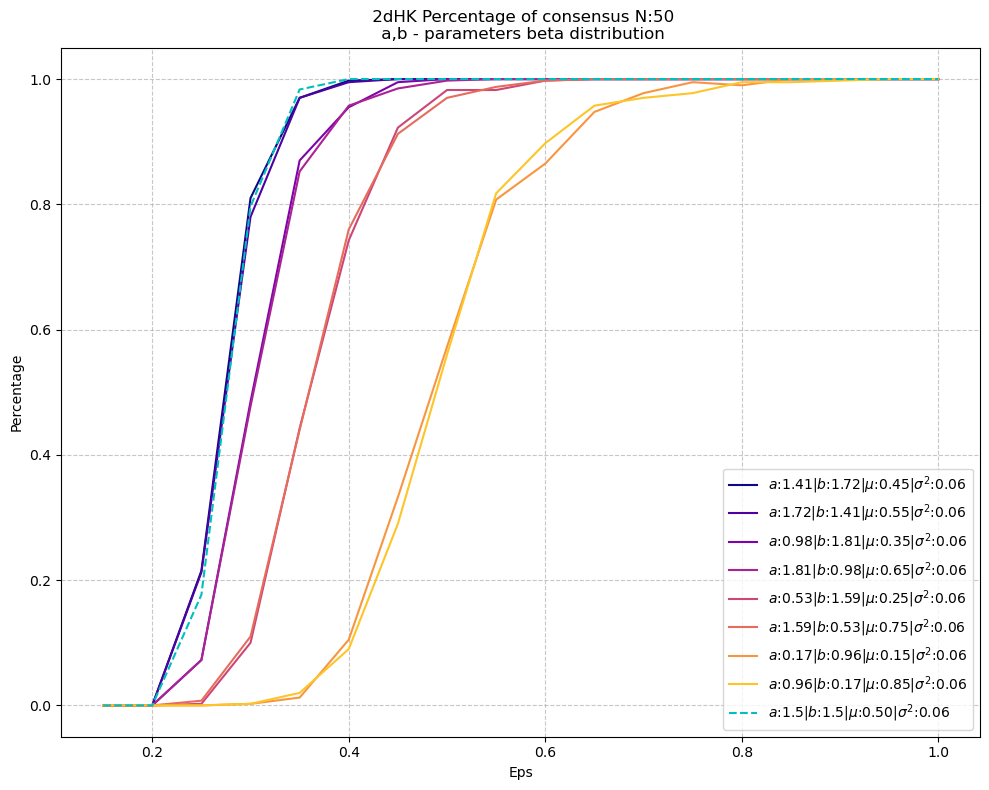

In [18]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0, vmax=len(alphas))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(alphas)):
    alpha = alphas[i]
    beta = betas[i]
    df = beta_distib_consensus_data.query('beta==@beta and alpha==@alpha and N == @N')
    color=np.array(cmap(norm(i)))
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

df = beta_distib_consensus_data.query('beta==1.5 and alpha==1.5 and N == @N')
color="--c"
alpha=beta = 1.5
E, sigma = beta_distrib_ab2Esigma(1.5, 1.5)
plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], color ,label=f'$a$:{round(alpha,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}' )

# plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [57]:
%matplotlib inline

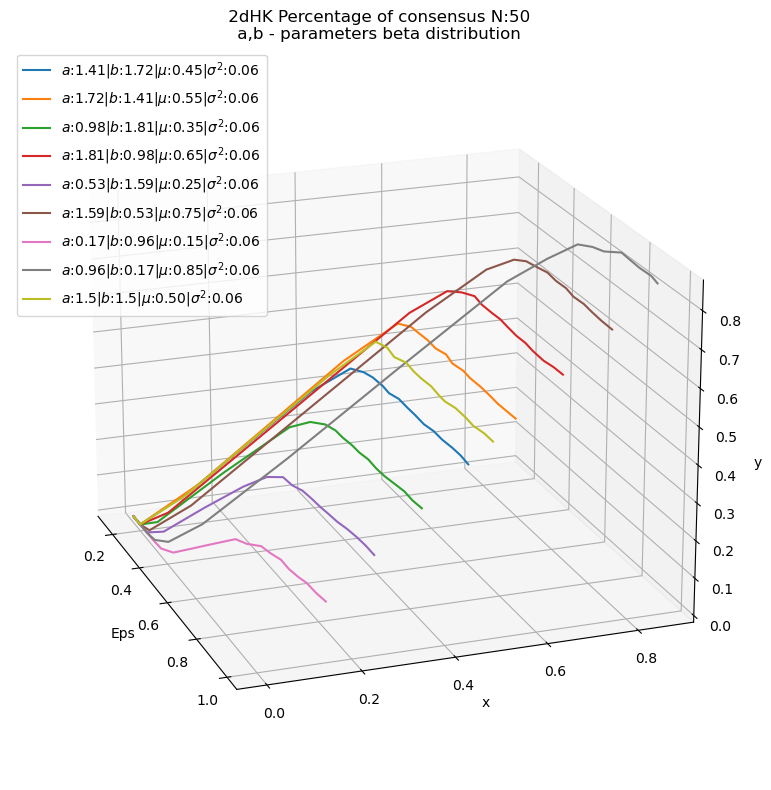

In [58]:


ax = plt.figure(figsize=(10, 8)).add_subplot(projection='3d')

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0, vmax=len(alphas))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(alphas)):
    alpha = alphas[i]
    beta = betas[i]
    df = beta_distib_consensus_data.query('beta==@beta and alpha==@alpha and N == @N')
    color=np.array(cmap(norm(i)))
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    ax.plot3D(xs=df['eps'], ys=df['consensus_x']/df['simulation_count'], zs=df['consensus_y']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}' )

df = beta_distib_consensus_data.query('beta==1.5 and alpha==1.5 and N == @N')
color="--c"
alpha=beta = 1.5
E, sigma = beta_distrib_ab2Esigma(1.5, 1.5)
ax.plot3D(xs=df['eps'], ys=df['consensus_x']/df['simulation_count'], zs=df['consensus_y']/df['simulation_count'],label=f'$a$:{round(alpha,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}' )

# plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
ax.set_xlabel('Eps')
ax.set_ylabel('x')
ax.set_zlabel('y')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)
ax.view_init(elev=20., azim=-20)


plt.tight_layout()
plt.show()

#### Моделирование для $\alpha=\beta, \mu=0.5$ - фиксированное

In [ ]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for beta in beta_params_array:
        alpha = beta
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                     & (beta_distib_consensus_data['alpha'] == alpha) 
                     & (beta_distib_consensus_data['beta'] == beta) 
                     & (beta_distib_consensus_data['eps'] == R))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

In [ ]:
beta_distib_consensus_data[beta_distib_consensus_data['N'] == 50]


#### Сохранение

In [73]:
beta_distib_consensus_data.to_csv('beta_distib_consensus_data.csv',sep=";", index=False)

#### Загрузка результатов

In [ ]:
data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
data
# data = beta_distib_consensus_data

#### Визуализация

In [ ]:
N50 = data[data['N'] == N]
pivot_data = N50.pivot(index='eps', columns='beta', values='consensus_probabity')
pivot_data

In [ ]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0.15, vmax=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for beta in beta_params_array:
    df = data.query('beta == @beta and N == @N')
    color=np.array(cmap(norm(beta)))
    alpha = beta
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(beta,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()